In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import fft
import seaborn as sns
import pandas as pd

import matplotlib as mpl
mpl.rcParams["font.size"]=15

In [2]:
# definition of root paths
root_dir = '/Users/zcaspar/codes/mit4320/'
fig_dir = '/Users/zcaspar/Documents/Figures_paper2/'

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_maps(ds,colmap='RdBu_r',vlim=(-0.01,0.01),axes=111,lat='lat_bin',**kwargs):
    """
    Plot maps of a given xarray.
    ----------------------------------------------
    Parameters:
    ds : xarray, 2D variable
    colmap : colormap to use in the plot (see list of colormaps on matplotlib), default is 'RdBu_r'
    vlim : tuple, limits of the colorbar (vmin, vmax)
    axes : subplots definition, default is one figure (111)
    lat : str, name of the latitude axis, default is 'lat_bin'
    kwargs : dict, properties of the colorbar (example: {'orientation':'horizontal'})
    """
    crs = ccrs.Robinson()
    #fig = plt.figure(figsize=figsize)
    cbar_kwargs = {'fraction':0.02}
    cbar_kwargs.update(**kwargs)
    ax = fig.add_subplot(axes,projection=crs)
    ds.plot(vmax=vlim[1],vmin=vlim[0],y=lat,ax=ax,
            transform=ccrs.PlateCarree(),cmap=colmap,label=False,#**kwargs,
            cbar_kwargs=cbar_kwargs) #{'fraction':0.02,'label':'energy'}
    ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND)
    return fig,ax

In [4]:
#Load energy files
ds_dl1 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_hf_binned_dl1.0.nc'),
                   xr.open_dataset(root_dir+'energy_SSV_hf_binned_dl1.0.nc'),
                   xr.open_dataset(root_dir+'energy_hf_binned_dl1.0.nc')])
ds_hf = ds_dl1.where(ds_dl1.waterdepth>500)

ds_dl2 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_hf_binned_dl2.0.nc'),
                   xr.open_dataset(root_dir+'energy_SSV_hf_binned_dl2.0.nc'),
#                   xr.open_dataset(root_dir+'energy_hf_binned_dl2.0.nc')
                  ])
ds_hf_dl2 = ds_dl2.where(ds_dl2.waterdepth>500)
for v in ['E','L']:
    ds_hf_dl2[v+'_energy'] = ds_hf_dl2[v+'_energy_SSU']+ds_hf_dl2[v+'_energy_SSV']

ds_low_dl1 = xr.merge([xr.open_dataset(root_dir+'energy_SSU_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_dir+'energy_SSV_low_binned_dl1.0.nc'),
                       xr.open_dataset(root_dir+'energy_low_binned_dl1.0.nc')])

ds_low_dl1 = ds_low_dl1.where(ds_low_dl1.waterdepth>500)

In [5]:
ds_gdp = xr.open_dataset(root_dir+'gdp_combined.nc')
ds_gdp = ds_gdp.rename({'lon':'lon_bin','lat':'lat_bin'})
ds_gdp['energy'] = ds_gdp['semidiurnal_ve_abs2_mean']+ds_gdp['semidiurnal_vn_abs2_mean']
ds_gdp = ds_gdp.sel(lat_bin=slice(-60,60))

In [6]:
ds_gdp

<xarray.Dataset>
Dimensions:                   (type: 2, lon_bin: 179, lat_bin: 60)
Coordinates:
    dA                        (lat_bin) float64 ...
    h                         (lon_bin, lat_bin) float64 ...
  * lat_bin                   (lat_bin) float64 -59.0 -57.0 -55.0 ... 57.0 59.0
  * lon_bin                   (lon_bin) float64 -179.0 -177.0 ... 175.0 177.0
  * type                      (type) object 'gps' 'argos'
Data variables:
    semidiurnal_ve_abs2_mean  (type, lon_bin, lat_bin) float64 ...
    semidiurnal_vn_abs2_mean  (type, lon_bin, lat_bin) float64 ...
    dcount                    (type, lon_bin, lat_bin) float64 ...
    energy                    (type, lon_bin, lat_bin) float64 0.001153 ... 0...

In [10]:
ds_hf_dl2

<xarray.Dataset>
Dimensions:       (lon_bin: 179, lat_bin: 59)
Coordinates:
  * lon_bin       (lon_bin) float64 -179.0 -177.0 -175.0 ... 173.0 175.0 177.0
  * lat_bin       (lat_bin) float64 -59.0 -57.0 -55.0 -53.0 ... 53.0 55.0 57.0
Data variables:
    E_count       (lon_bin, lat_bin) float64 1.128e+03 1.08e+03 ... 1.056e+03
    E_energy_SSU  (lon_bin, lat_bin) float64 0.001649 0.001448 ... 0.01921
    L_energy_SSU  (lon_bin, lat_bin) float64 0.001451 0.001126 ... 0.01844
    waterdepth    (lon_bin, lat_bin) float64 4.554e+03 4.994e+03 ... 3.815e+03
    L_count       (lon_bin, lat_bin) float64 2.122e+03 2.306e+03 ... 2.653e+04
    E_energy_SSV  (lon_bin, lat_bin) float64 0.00143 0.001115 ... 0.01973
    L_energy_SSV  (lon_bin, lat_bin) float64 0.001339 0.0008138 ... 0.01898
    E_energy      (lon_bin, lat_bin) float64 0.003079 0.002563 ... 0.03894
    L_energy      (lon_bin, lat_bin) float64 0.00279 0.00194 ... 0.03706 0.03742

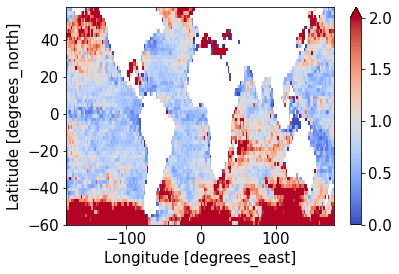

In [21]:
(5*ds_gdp.sum('type').semidiurnal_ve_abs2_mean/(ds_hf_dl2.E_energy_SSU)).plot(y='lat_bin',cmap='coolwarm',vmax=2)

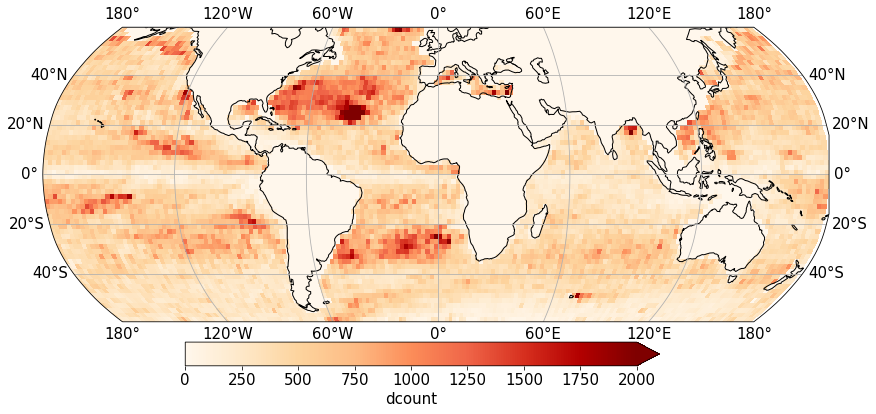

In [20]:
figsize = (15,6)
cmap = 'OrRd'
kwargs = {'orientation':'horizontal','pad':0.06,'fraction':0.07}
fig = plt.figure(figsize=figsize)
#kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig,ax = plot_maps(ds_gdp.dcount.sum("type"),colmap=cmap,vlim=(0,2000),**kwargs)
ax.set_title(r'',size=15)
fig.tight_layout()
fig.savefig(fig_dir+'Nb_gdp.png',bbox_inches='tight')

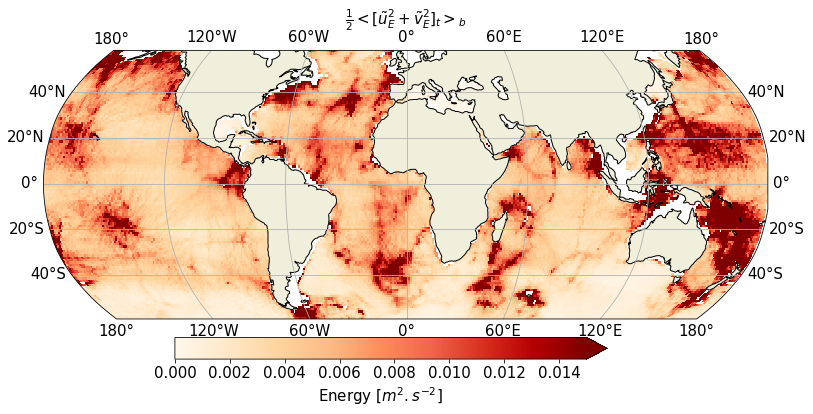

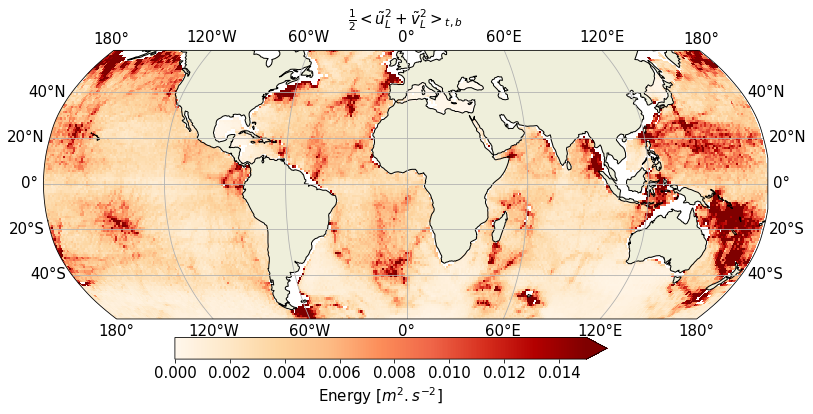

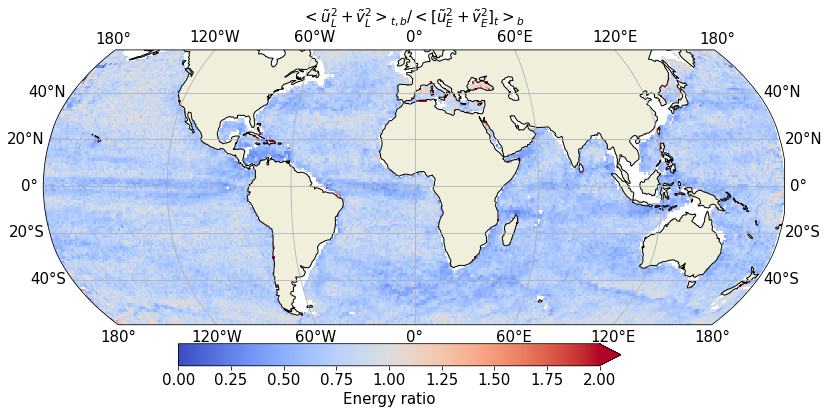

In [8]:
figsize = (15,6)
cmap = 'OrRd'
kwargs = {'orientation':'horizontal','pad':0.06,'fraction':0.07}
fig = plt.figure(figsize=figsize)
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig,ax = plot_maps(0.5*ds_hf.E_energy,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title(r'$\frac{1}{2}<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig(fig_dir+'E_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(0.5*ds_hf.L_energy,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title(r'$\frac{1}{2}<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}$',size=15)
fig.tight_layout()
#fig.savefig(fig_dir+'L_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_hf.L_energy/ds_hf.E_energy,colmap='coolwarm',vlim=(0.,2.),**kwargs)
#(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
#                                     y='lat_bin',levels=[0.025,0.09],colors=['grey','black'])
ax.set_title(r'$<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}/<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$'
             ,size=15)
fig.tight_layout()
#fig.savefig(fig_dir+'LE_energy_hf.png',bbox_inches='tight')



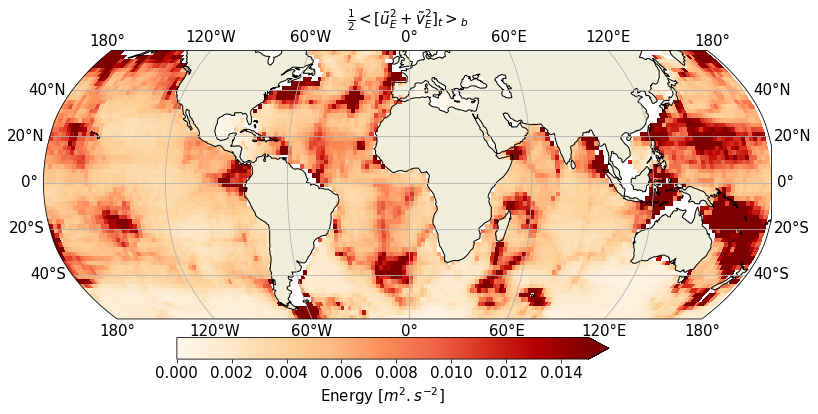

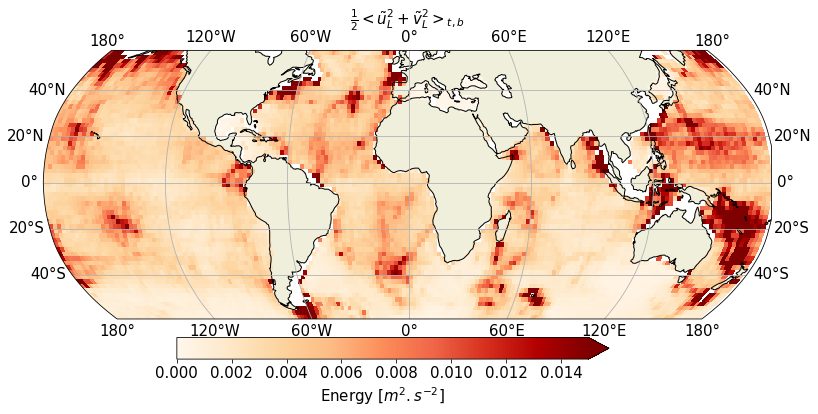

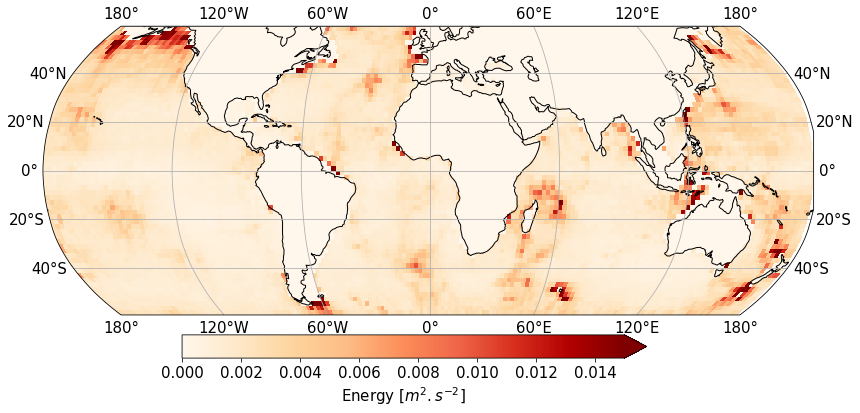

In [9]:
figsize = (15,6)
cmap = 'OrRd'
kwargs = {'orientation':'horizontal','pad':0.06,'fraction':0.07}
fig = plt.figure(figsize=figsize)
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig,ax = plot_maps(0.5*ds_hf_dl2.E_energy,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title(r'$\frac{1}{2}<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$',size=15)
fig.tight_layout()
#fig.savefig(fig_dir+'E_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(0.5*ds_hf_dl2.L_energy,colmap=cmap,vlim=(0,0.015),**kwargs)
ax.set_title(r'$\frac{1}{2}<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}$',size=15)
fig.tight_layout()
#fig.savefig(fig_dir+'L_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
#kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(2*ds_gdp.energy,lat='lat',colmap='OrRd',vlim=(0.,.015),**kwargs)
#(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
#                                     y='lat_bin',levels=[0.025,0.09],colors=['grey','black'])
#ax.set_title(r'$<\tilde{u}_L^2+\tilde{v}_L^2>_{t,b}/<[\tilde{u}_E^2+\tilde{v}_E^2]_t>_b$'
#             ,size=15)
fig.tight_layout()
fig.savefig(fig_dir+'Lgdp_energy.png',bbox_inches='tight')



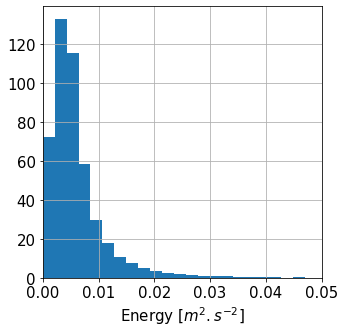

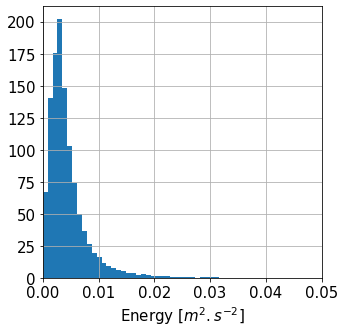

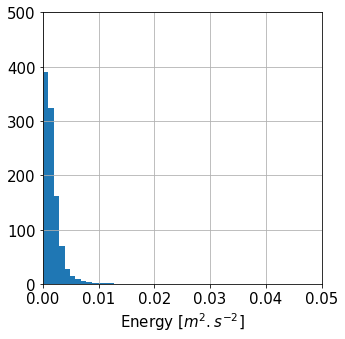

In [10]:
fig,ax = plt.subplots(figsize=(5,5))
_ = (0.5*ds_hf.E_energy).plot.hist(ax=ax,bins=1000,xlim=(0,0.05),density=True)
ax.grid();ax.set_xlabel(r'Energy [$m^2.s^{-2}$]')
fig.savefig(fig_dir+'E_energy_hist.png',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(5,5))
_ = (0.5*ds_hf.L_energy).plot.hist(ax=ax,bins=1000,xlim=(0,0.05),density=True)
ax.grid();ax.set_xlabel(r'Energy [$m^2.s^{-2}$]');
fig.savefig(fig_dir+'L_energy_hist.png',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(5,5))
_ = (2*ds_gdp.energy).plot.hist(ax=ax,bins=100,xlim=(0,0.05),ylim=(0,500),density=True)
ax.grid();ax.set_xlabel(r'Energy [$m^2.s^{-2}$]');
fig.savefig(fig_dir+'Lgdp_energy_hist.png',bbox_inches='tight')



In [17]:
ds_hf

<xarray.Dataset>
Dimensions:       (lon_bin: 359, lat_bin: 119)
Coordinates:
  * lon_bin       (lon_bin) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
  * lat_bin       (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
Data variables:
    E_count       (lon_bin, lat_bin) float64 288.0 276.0 276.0 ... 252.0 251.0
    E_energy_SSU  (lon_bin, lat_bin) float64 0.001918 0.001416 ... 0.03045
    L_energy_SSU  (lon_bin, lat_bin) float64 0.001947 0.0008158 ... 0.03117
    waterdepth    (lon_bin, lat_bin) float64 4.347e+03 4.968e+03 ... 3.745e+03
    L_count       (lon_bin, lat_bin) float64 217.0 215.0 ... 6.38e+03 2.066e+03
    E_energy_SSV  (lon_bin, lat_bin) float64 0.001605 0.001155 ... 0.02912
    L_energy_SSV  (lon_bin, lat_bin) float64 0.001742 0.0008039 ... 0.02922
    E_energy      (lon_bin, lat_bin) float64 0.003523 0.002571 ... 0.05957
    L_energy      (lon_bin, lat_bin) float64 0.003689 0.00162 ... 0.02651 0.0604

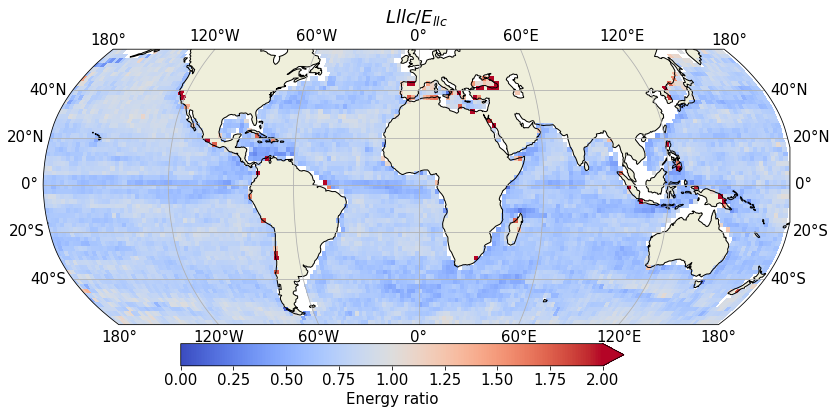

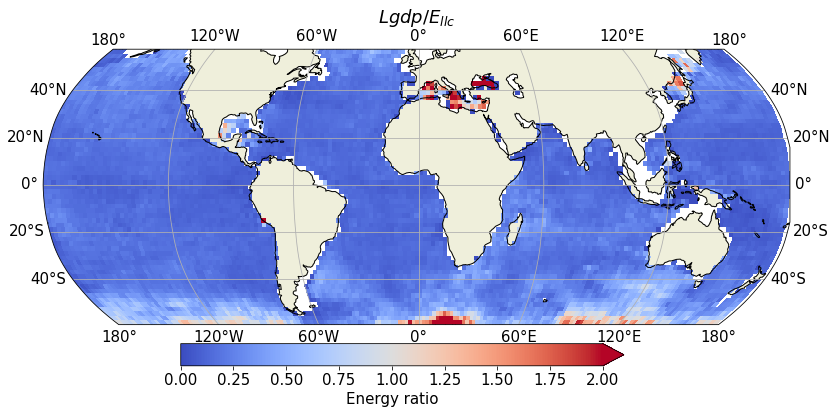

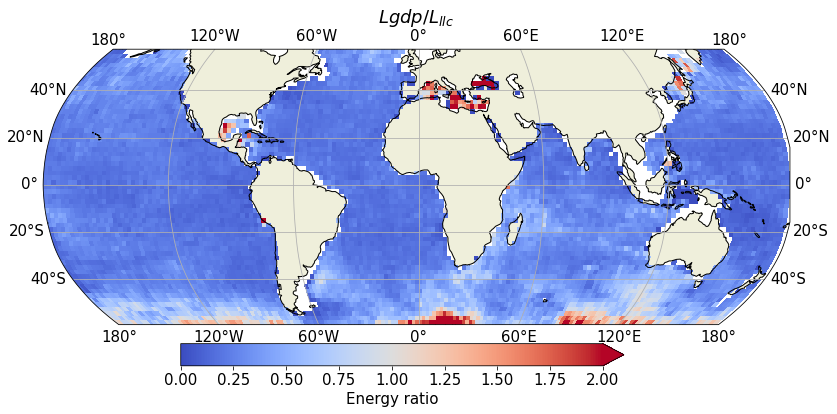

In [20]:
fig = plt.figure(figsize=figsize)
kwargs.update({'label': 'Energy ratio'})
fig,ax = plot_maps(ds_hf_dl2.L_energy/ds_hf_dl2.E_energy,colmap='coolwarm',vlim=(0.,2.),**kwargs)
#(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
#                                     y='lat_bin',levels=[0.025,0.09],colors=['grey','black'])
ax.set_title(r'$L{llc}/E_{llc}$')
fig.tight_layout()
#fig.savefig(fig_dir+'LE_energy_hf.png',bbox_inches='tight')


fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*ds_gdp.energy/ds_hf_dl2.E_energy,colmap='coolwarm',vlim=(0.,2.),**kwargs)
#(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
#                                     y='lat_bin',levels=[0.025,0.09],colors=['grey','black'])
ax.set_title(r'$L{gdp}/E_{llc}$')
fig.tight_layout()
#fig.savefig(fig_dir+'LE_energy_hf.png',bbox_inches='tight')

fig = plt.figure(figsize=figsize)
fig,ax = plot_maps(2*ds_gdp.energy/ds_hf_dl2.L_energy,colmap='coolwarm',vlim=(0.,2.),**kwargs)
#(ds_low_dl1['L_energy_smooth']).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
#                                     y='lat_bin',levels=[0.025,0.09],colors=['grey','black'])
ax.set_title(r'$L{gdp}/L_{llc}$')
fig.tight_layout()


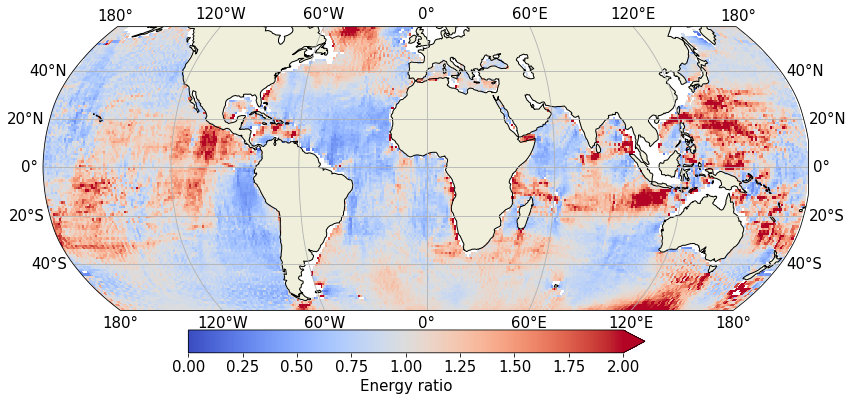

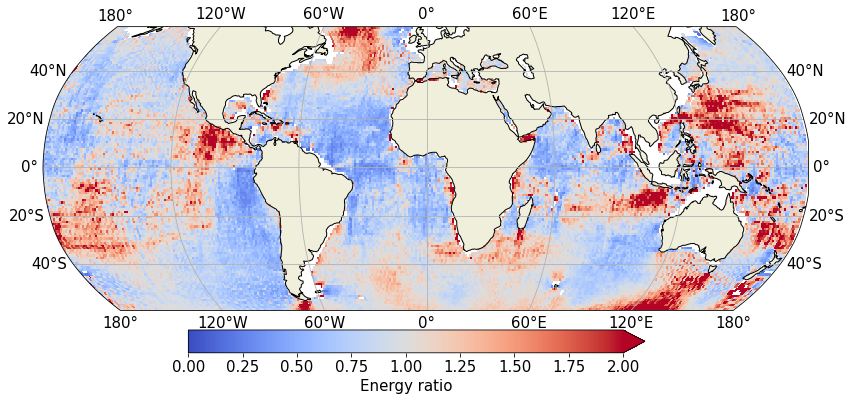

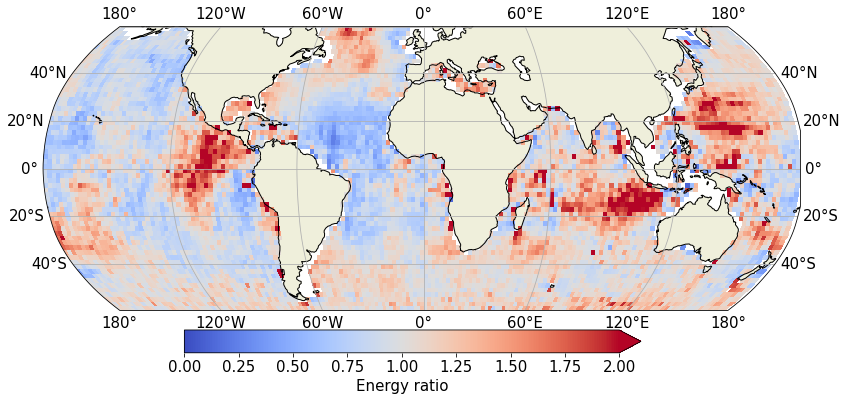

In [22]:
kwargs = {'orientation':'horizontal','pad':0.06,'fraction':0.07,'label':'Energy ratio'}
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_hf.E_energy_SSU/ds_hf.E_energy_SSV,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
fig.savefig(fig_dir+'E_UV.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_hf.L_energy_SSU/ds_hf.L_energy_SSV,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
fig.savefig(fig_dir+'L_UV.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_gdp.semidiurnal_ve_abs2_mean/ds_gdp.semidiurnal_vn_abs2_mean,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
fig.savefig(fig_dir+'Lgdp_UV.png')




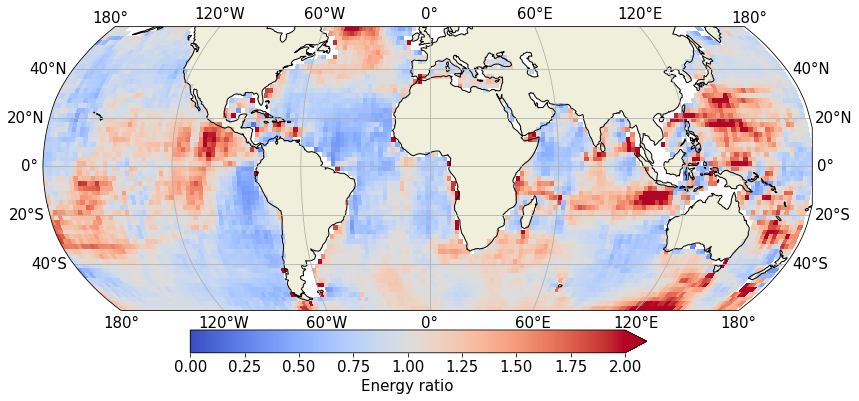

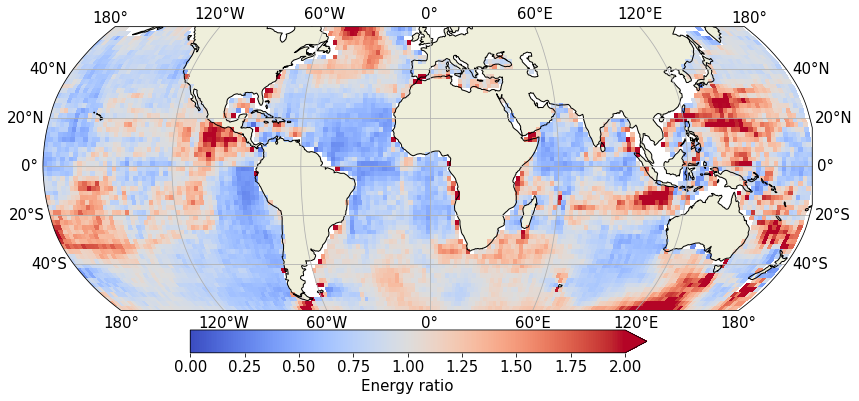

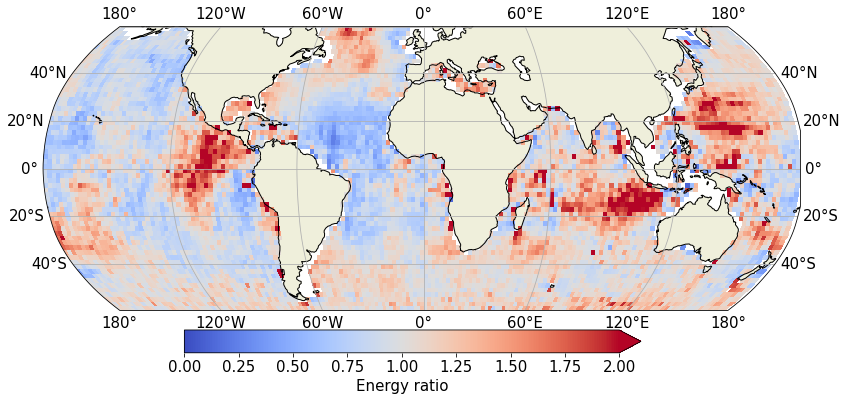

In [23]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_hf_dl2.E_energy_SSU/ds_hf_dl2.E_energy_SSV,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
#fig.savefig(fig_dir+'E_UV.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_hf_dl2.L_energy_SSU/ds_hf_dl2.L_energy_SSV,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
#fig.savefig(fig_dir+'L_UV.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_gdp.semidiurnal_ve_abs2_mean/ds_gdp.semidiurnal_vn_abs2_mean,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
fig.savefig(fig_dir+'Lgdp_UV.png')

Text(0.5, 1.0, '$L_{gdp}/L_{llc}$')

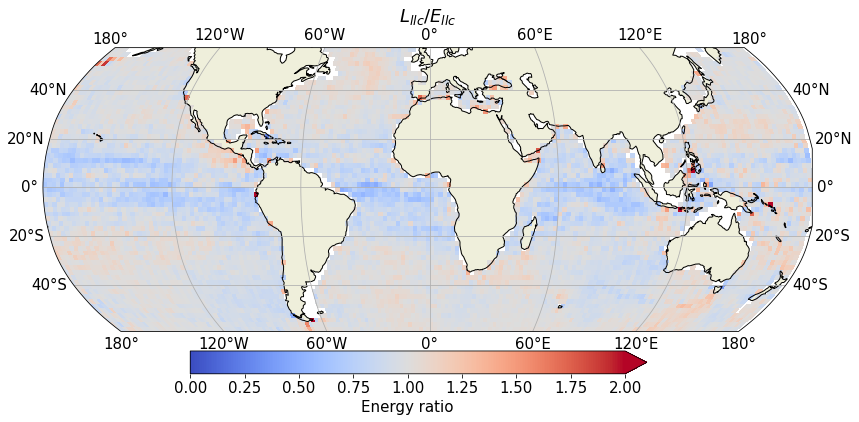

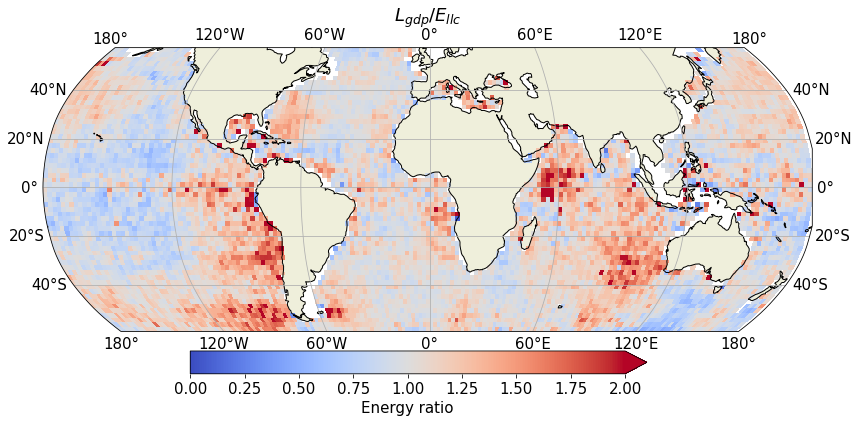

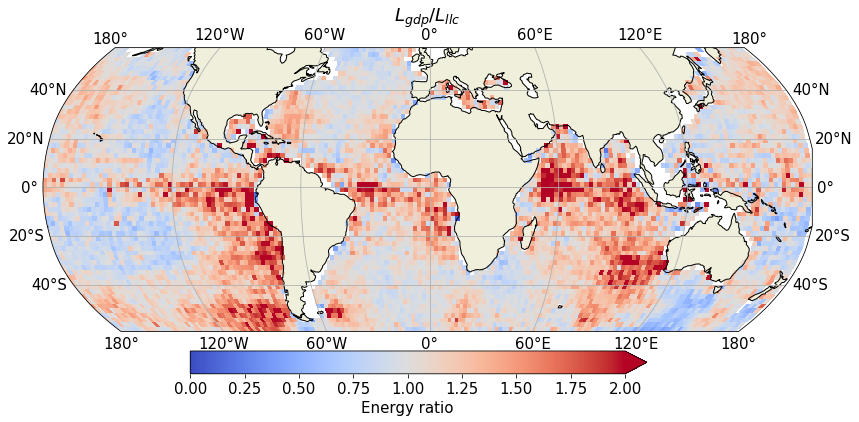

In [24]:

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_hf_dl2.E_energy_SSV*ds_hf_dl2.L_energy_SSU/(ds_hf_dl2.L_energy_SSV*ds_hf_dl2.E_energy_SSU)
                   ,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
ax.set_title(r'$L_{llc}/E_{llc}$')
#fig.savefig(fig_dir+'E_UV.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps((ds_hf_dl2.E_energy_SSV*ds_gdp.semidiurnal_ve_abs2_mean
                   )/(ds_gdp.semidiurnal_vn_abs2_mean*ds_hf_dl2.E_energy_SSU)
                   ,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
ax.set_title(r'$L_{gdp}/E_{llc}$')
#fig.savefig(fig_dir+'L_UV.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps((ds_hf_dl2.L_energy_SSV*ds_gdp.semidiurnal_ve_abs2_mean
                   )/(ds_gdp.semidiurnal_vn_abs2_mean*ds_hf_dl2.L_energy_SSU)
                   ,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
ax.set_title(r'$L_{gdp}/L_{llc}$')

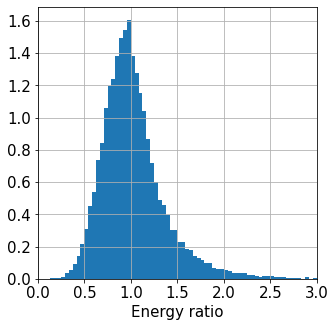

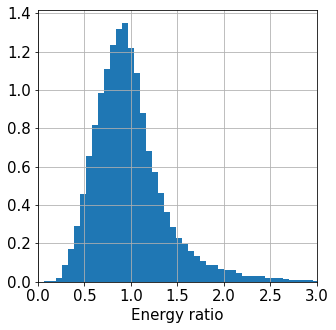

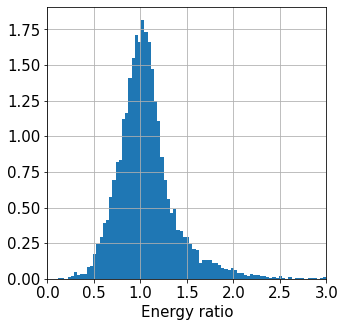

In [25]:
fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_hf.E_energy_SSU/ds_hf.E_energy_SSV).plot.hist(ax=ax,bins=100,xlim=(0,3),density=True)
ax.grid();ax.set_xlabel(r'Energy ratio')
fig.savefig(fig_dir+'E_UV_hist.png',bbox_inches='tight')

fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_hf.L_energy_SSU/ds_hf.L_energy_SSV).plot.hist(ax=ax,bins=100,xlim=(0,3),density=True)
ax.grid();ax.set_xlabel(r'Energy ratio');
fig.savefig(fig_dir+'L_UV_hist.png',bbox_inches='tight')


fig,ax = plt.subplots(figsize=(5,5))
_ = (ds_gdp.semidiurnal_ve_abs2_mean/ds_gdp.semidiurnal_vn_abs2_mean).plot.hist(ax=ax,bins=1000,xlim=(0,3),density=True)
ax.grid();ax.set_xlabel(r'Energy ratio');
fig.savefig(fig_dir+'Lgdp_UV_hist.png',bbox_inches='tight')




In [28]:
ds_gdp

<xarray.Dataset>
Dimensions:                   (lon_bin: 179, lat_bin: 60)
Coordinates:
    dA                        (lat_bin) float64 ...
    h                         (lon_bin, lat_bin) float64 ...
  * lat_bin                   (lat_bin) float64 -59.0 -57.0 -55.0 ... 57.0 59.0
  * lon_bin                   (lon_bin) float64 -179.0 -177.0 ... 175.0 177.0
Data variables:
    semidiurnal_ve_abs2_mean  (lon_bin, lat_bin) float64 ...
    semidiurnal_vn_abs2_mean  (lon_bin, lat_bin) float64 ...
    energy                    (lon_bin, lat_bin) float64 0.001492 ... 0.001564

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warn

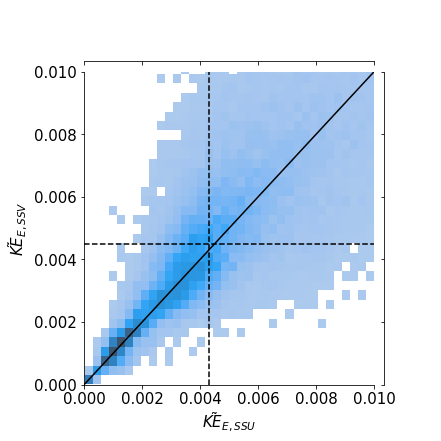

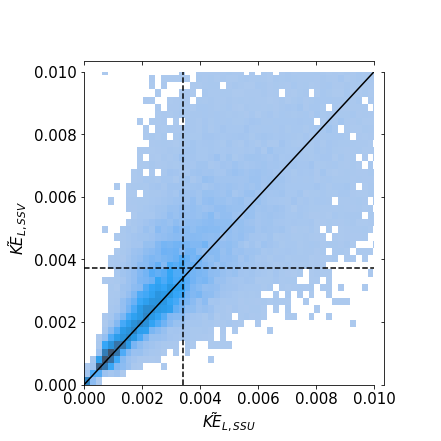

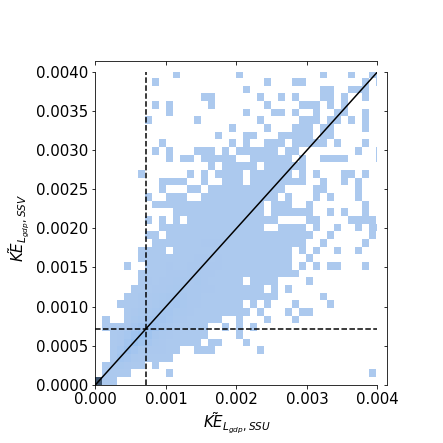

In [32]:
x = (ds_hf.E_energy_SSU).values.flatten()
y = (ds_hf.E_energy_SSV).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.01),ylim=(0,0.01))
axs = g.plot_joint(sns.histplot)
axs.set_axis_labels(r'$\tilde{KE}_{E,SSU}$',
                        r'$\tilde{KE}_{E,SSV}$');
axs.ax_joint.axvline(axs.x[axs.x<0.01].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.01].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
#fig.savefig(fig_dir+'LE_gdp_joint.png')

x = (ds_hf.L_energy_SSU).values.flatten()
y = (ds_hf.L_energy_SSV).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.01),ylim=(0,0.01))
axs = g.plot_joint(sns.histplot)
axs.set_axis_labels(r'$\tilde{KE}_{L,SSU}$',
                        r'$\tilde{KE}_{L,SSV}$');
axs.ax_joint.axvline(axs.x[axs.x<0.01].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.01].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
#fig.savefig(fig_dir+'LE_gdp_joint.png')

x = (2*ds_gdp.semidiurnal_ve_abs2_mean).values.flatten()
y = (2*ds_gdp.semidiurnal_vn_abs2_mean).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.004),ylim=(0,0.004))
axs = g.plot_joint(sns.histplot)
axs.set_axis_labels(r'$\tilde{KE}_{L_{gdp},SSU}$',
                        r'$\tilde{KE}_{L_{gdp},SSV}$');
axs.ax_joint.axvline(axs.x[axs.x<0.004].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.004].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
#fig.savefig(fig_dir+'LE_gdp_joint.png')

In [31]:

ds_predicted = xr.open_dataset(root_dir+'prediction_mode2.nc')
ds_predicted = ds_predicted.rename({'lon_bins':'lon_bin','lat_bins':'lat_bin'})

In [33]:
ds_predicted['energy_ratio'] = (ds_predicted['El']+ds_predicted['El_V'])/(ds_predicted['Ee']+ds_predicted['Ee_V'])

In [34]:
ds_gdp['E_energy'] = ds_gdp.energy/ds_predicted.energy_ratio

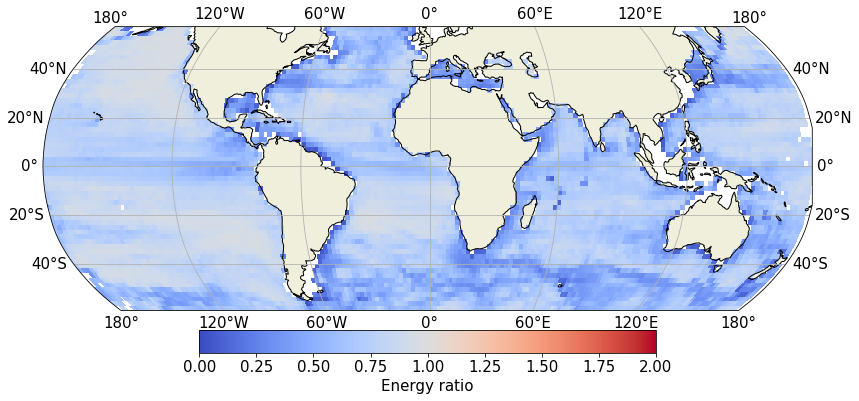

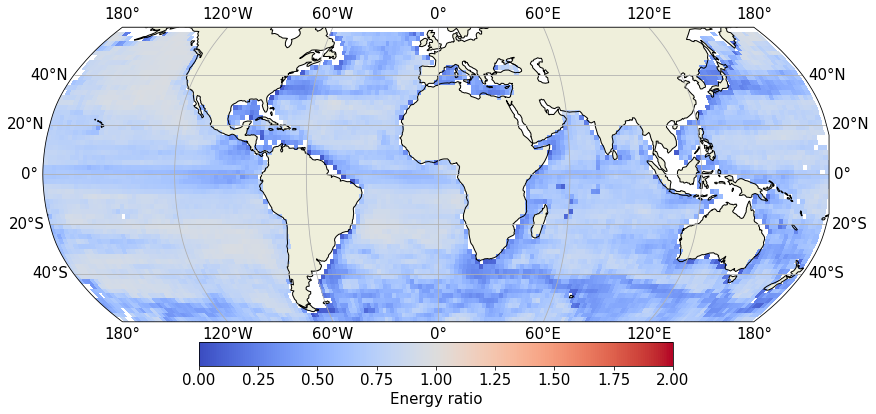

In [35]:
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_predicted.energy_ratio,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(ds_gdp.energy/ds_gdp.E_energy,lat='lat_bin',vlim=(0,2),colmap='coolwarm',**kwargs)
fig.tight_layout();
fig.savefig(fig_dir+'LE_gdp.png')

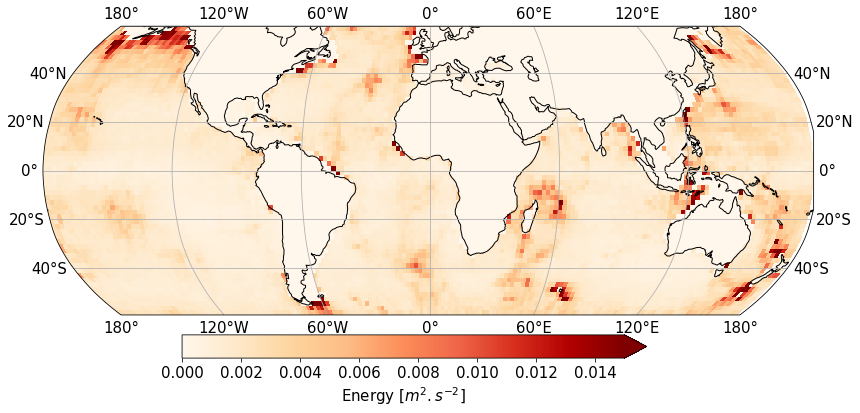

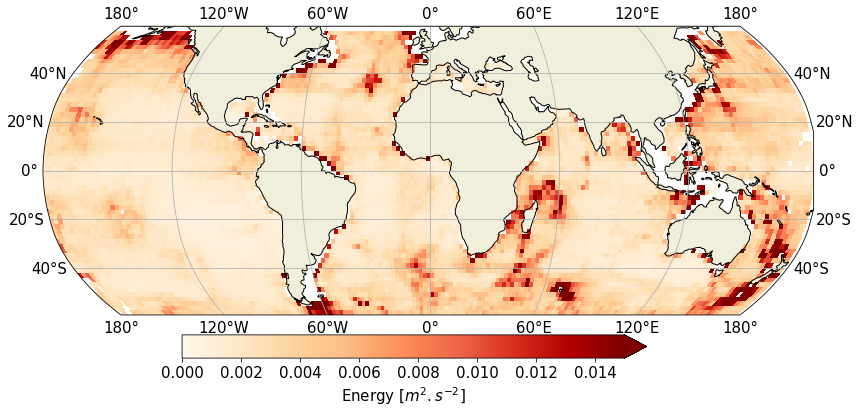

In [36]:
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(2*ds_gdp.energy,lat='lat_bin',vlim=(0,0.015),colmap='OrRd',**kwargs)
fig.tight_layout();
#fig.savefig(fig_dir+'E_gdp_predicted.png')

fig = plt.figure(figsize=(15,6))
fig,ax = plot_maps(2*ds_gdp.E_energy,lat='lat_bin',vlim=(0,0.015),colmap='OrRd',**kwargs)
fig.tight_layout();
fig.savefig(fig_dir+'E_gdp_predicted.png')

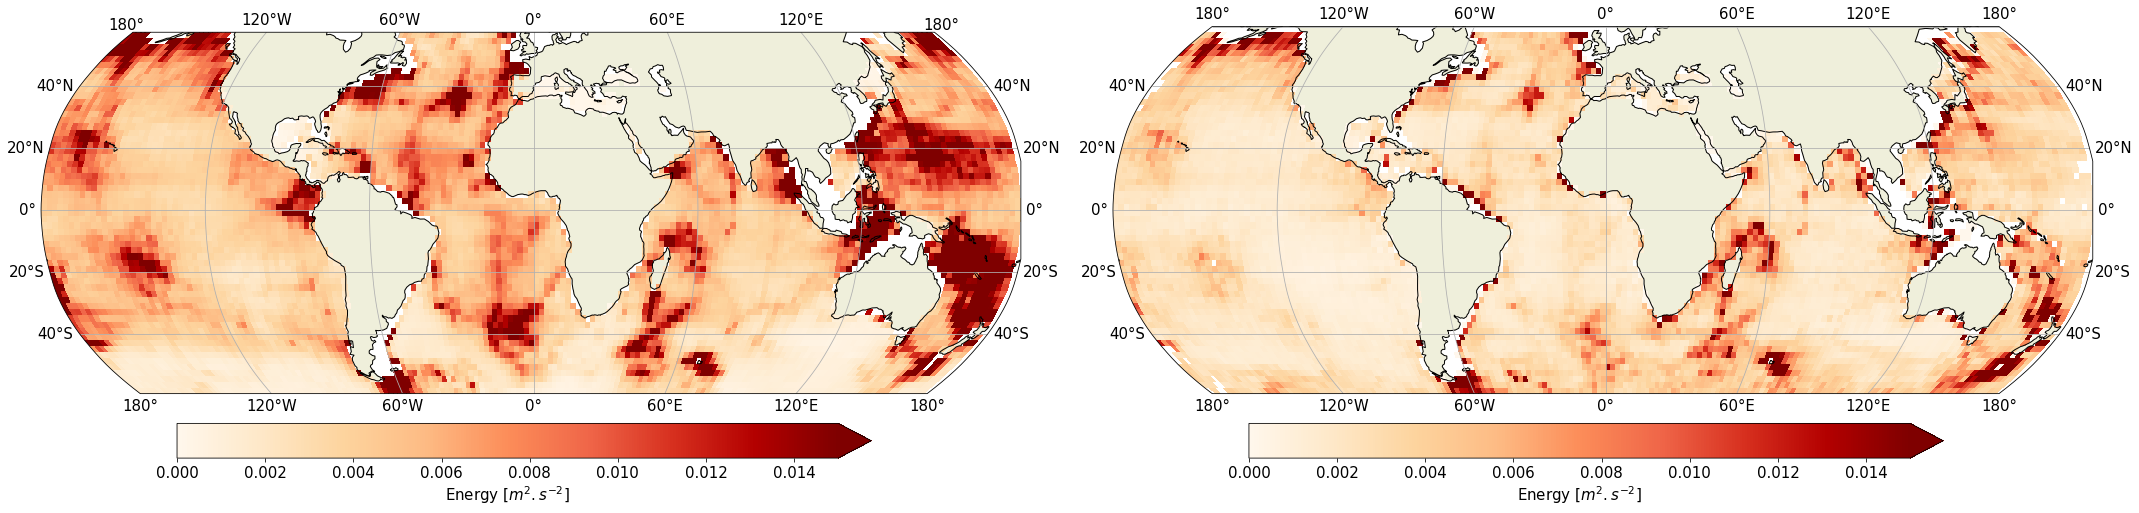

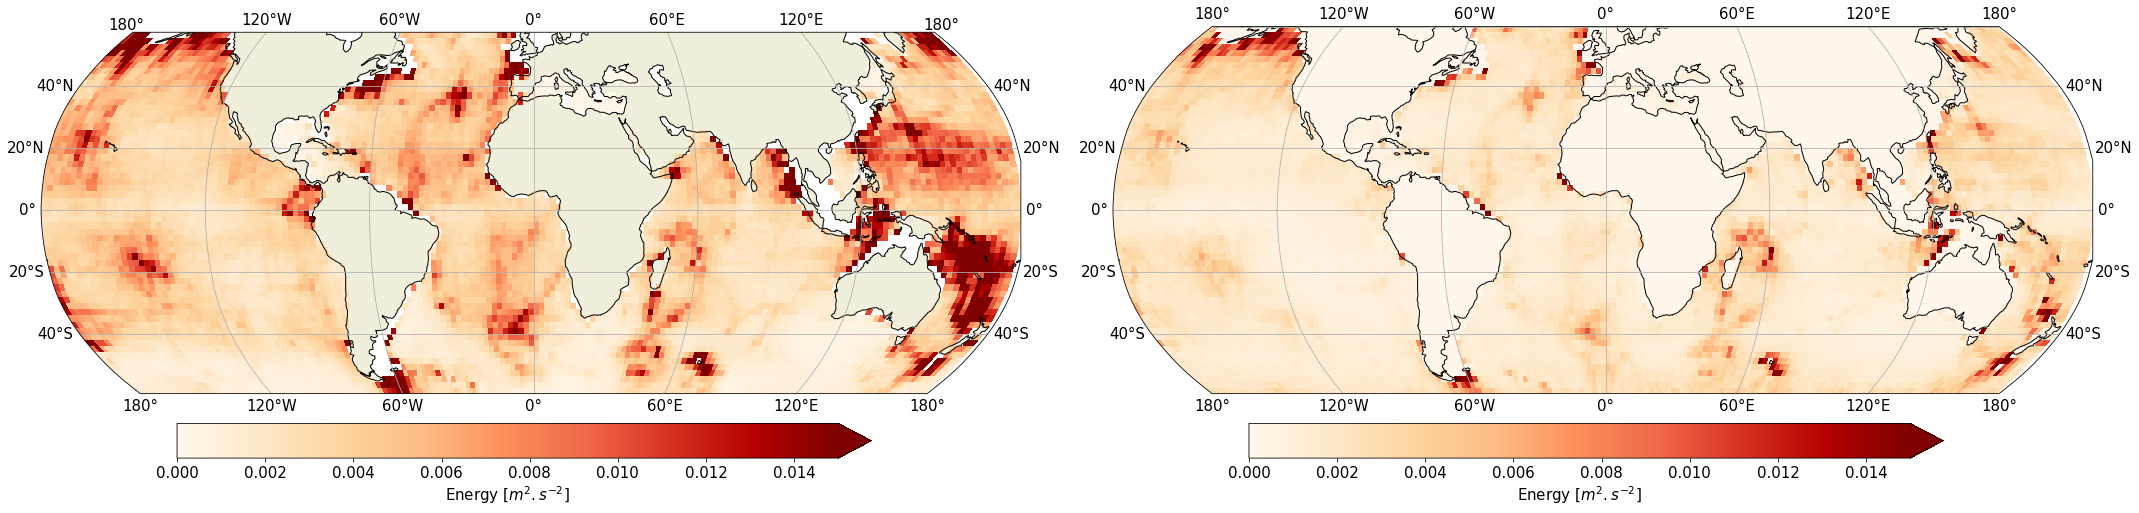

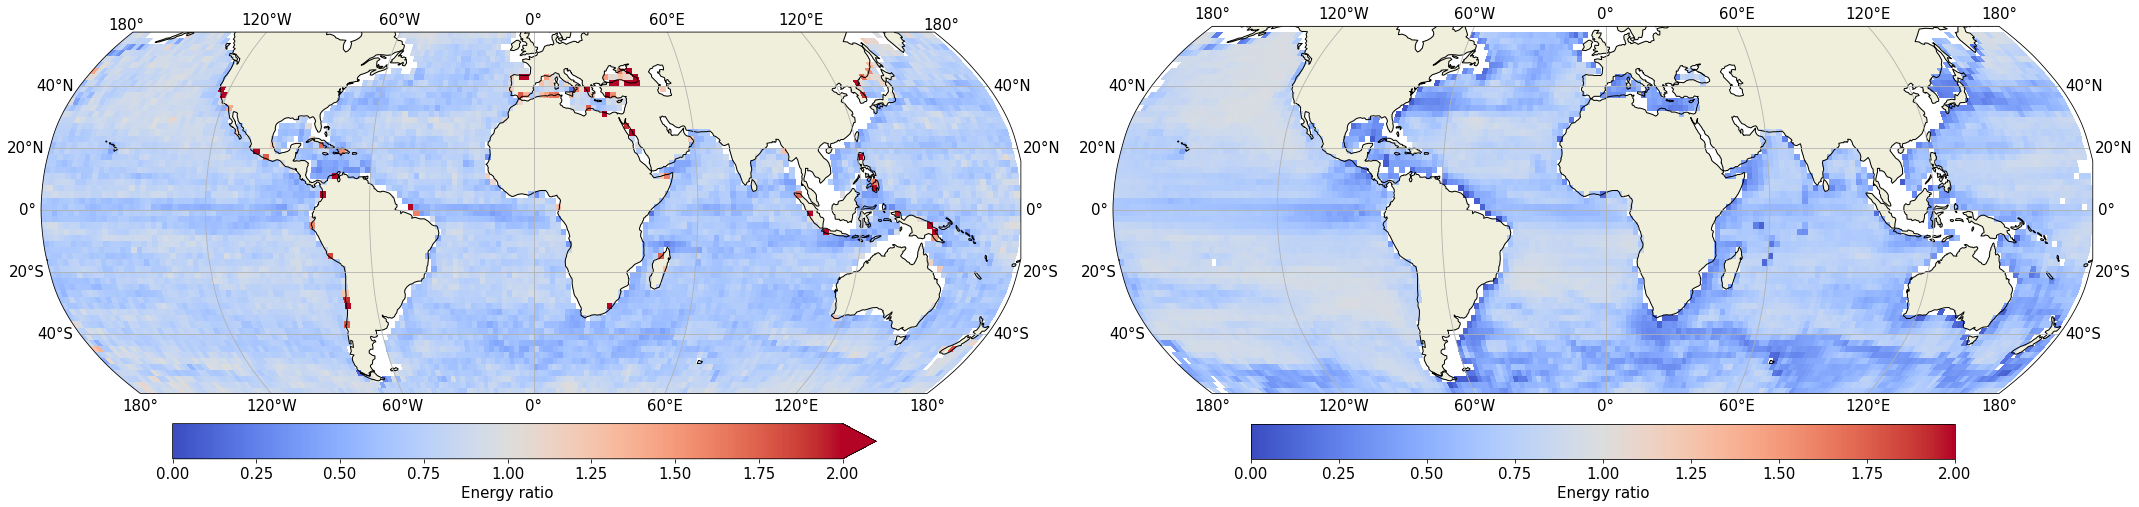

In [37]:
kwargs.update({'label':r'Energy [$m^2.s^{-2}$]'})
fig = plt.figure(figsize=(30,8))
fig,ax = plot_maps(0.5*ds_hf_dl2.E_energy,lat='lat_bin',axes=121,vlim=(0,0.015),colmap='OrRd',**kwargs)
fig,ax = plot_maps(2*ds_gdp.E_energy,lat='lat_bin',axes=122,vlim=(0,0.015),colmap='OrRd',**kwargs)
fig.tight_layout();
#fig.savefig(fig_dir+'E_gdp_predicted.png')

fig = plt.figure(figsize=(30,8))
fig,ax = plot_maps(0.5*ds_hf_dl2.L_energy,lat='lat_bin',axes=121,vlim=(0,0.015),colmap='OrRd',**kwargs)
fig,ax = plot_maps(2*ds_gdp.energy,lat='lat_bin',axes=122,vlim=(0,0.015),colmap='OrRd',**kwargs)
fig.tight_layout();

kwargs.update({'label':'Energy ratio'})
fig = plt.figure(figsize=(30,8))
fig,ax = plot_maps(ds_hf_dl2.L_energy/ds_hf_dl2.E_energy,lat='lat_bin',
                   axes=121,vlim=(0,2),colmap='coolwarm',**kwargs)
fig,ax = plot_maps(ds_gdp.energy/ds_gdp.E_energy,lat='lat_bin',
                   axes=122,vlim=(0,2),colmap='coolwarm',**kwargs)
fig.tight_layout();

In [109]:
g.plot_joint?

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'bins'
  cset = contour_func(
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


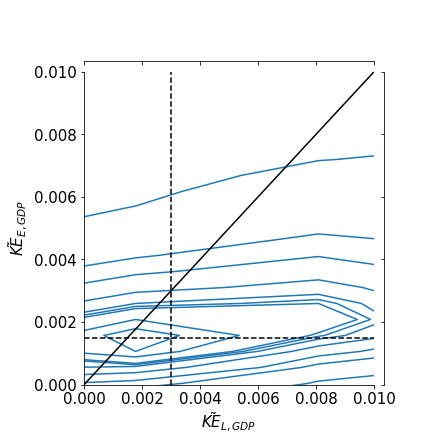

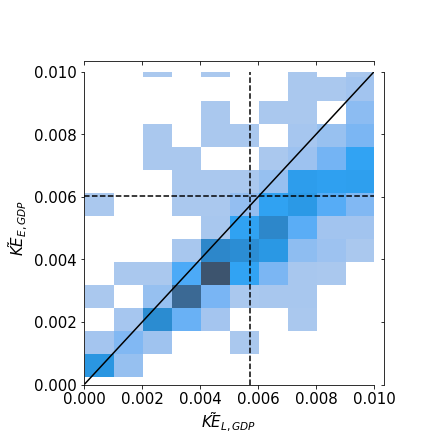

In [43]:
x = (2*ds_gdp.E_energy).values.flatten()
y = (2*(ds_gdp.energy)).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.01),ylim=(0,0.01))
axs = g.plot_joint(sns.kdeplot,bins=10000)
axs.set_axis_labels(r'$\tilde{KE}_{L,GDP}$',
                        r'$\tilde{KE}_{E,GDP}$');
axs.ax_joint.axvline(axs.x[axs.x<0.01].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.01].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
#fig.savefig(fig_dir+'LE_gdp_joint.png')

x = (2*ds_hf_dl2.E_energy).values.flatten()
y = (2*(ds_hf_dl2.L_energy)).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.01),ylim=(0,0.01))
axs = g.plot_joint(sns.histplot,bins=10000)
axs.set_axis_labels(r'$\tilde{KE}_{L,GDP}$',
                        r'$\tilde{KE}_{E,GDP}$');
axs.ax_joint.axvline(axs.x[axs.x<0.01].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.01].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
#fig.savefig(fig_dir+'LE_gdp_joint.png')

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


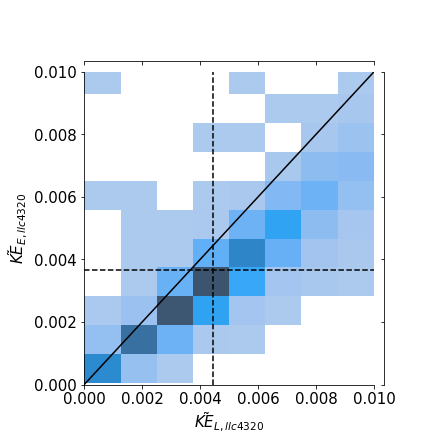

In [122]:
x = 0.5*ds_hf_dl2.E_energy.values.flatten()
y = (0.5*(ds_hf_dl2.L_energy)).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.01),ylim=(0,0.01))
axs = g.plot_joint(sns.histplot,bins=2000)
axs.set_axis_labels(r'$\tilde{KE}_{L,llc4320}$',
                        r'$\tilde{KE}_{E,llc4320}$');
axs.ax_joint.axvline(axs.x[axs.x<0.01].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.01].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
fig.savefig(fig_dir+'LE_joint.png')

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


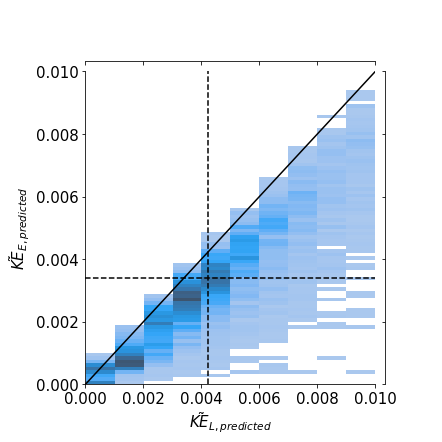

In [121]:
x = (ds_predicted.Ee+ds_predicted.Ee_V).values.flatten()
y = (ds_predicted.El+ds_predicted.El_V).values.flatten()
g = sns.JointGrid(x, y,xlim=(0,0.01),ylim=(0,0.01))
axs = g.plot_joint(sns.histplot,bins=2000)
axs.set_axis_labels(r'$\tilde{KE}_{L,predicted}$',
                        r'$\tilde{KE}_{E,predicted}$');
axs.ax_joint.axvline(axs.x[axs.x<0.01].mean(), color='k', ls='--', lw=1.5)
#    for ax in (axs.ax_joint, axs.ax_marg_y):
axs.ax_joint.axhline(axs.y[axs.y<0.01].mean(), color='k', ls='--', lw=1.5);
axs.ax_joint.plot(np.sort(x),np.sort(x),c='k',lw=1.5)
    #for ax in (axs.ax_joint):
    #g.plot(lambda x : x)#, c='k', lw=0.5)
fig = axs.figure
fig.savefig(fig_dir+'LE_predicted_joint.png')

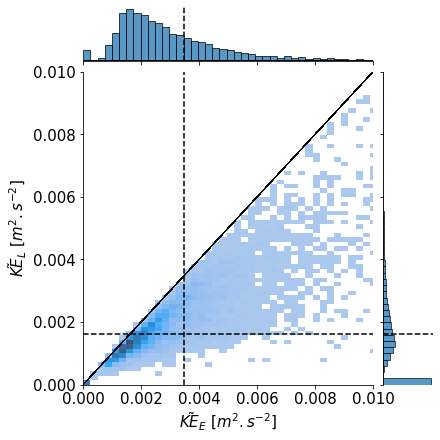

In [97]:
_El = (2*ds_gdp.energy).values.flatten()
_Ee = (2*ds_gdp.E_energy).values.flatten()
axs = sns.jointplot(x=_Ee,y=_El,kind='hist',xlim=(0,0.01),ylim=(0,0.01))
axs.set_axis_labels(r'$\tilde{KE}_E$ [$m^2.s^{-2}$]',r'$\tilde{KE}_L$ [$m^2.s^{-2}$]')
for ax in (axs.ax_joint, axs.ax_marg_x):
    ax.axvline(axs.x[axs.x<0.03].mean(), color='k', ls='--', lw=1.5)
for ax in (axs.ax_joint, axs.ax_marg_y):
    ax.axhline(axs.y[axs.y<0.03].mean(), color='k', ls='--', lw=1.5)
for ax in (axs.ax_joint, axs.ax_marg_x):
    ax.plot(axs.x.values,axs.x.values, c='k', lw=0.5)
fig = axs.figure

#fig.tight_layout()
fig.savefig(fig_dir+'LE_gdp_joint.png')

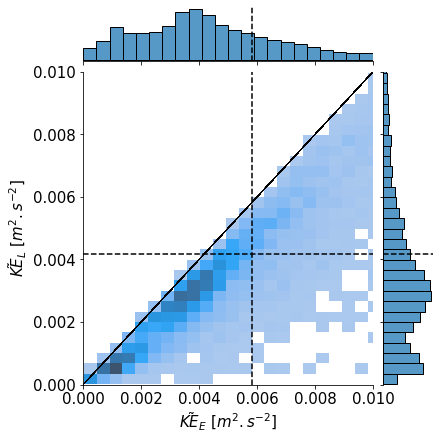

In [98]:
_El = (ds_predicted.El+ds_predicted.El_V).values.flatten()
_Ee = (ds_predicted.Ee+ds_predicted.Ee_V).values.flatten()
axs = sns.jointplot(x=_Ee,y=_El,kind='hist',xlim=(0,0.01),ylim=(0,0.01))
axs.set_axis_labels(r'$\tilde{KE}_E$ [$m^2.s^{-2}$]',r'$\tilde{KE}_L$ [$m^2.s^{-2}$]')
for ax in (axs.ax_joint, axs.ax_marg_x):
    ax.axvline(axs.x[axs.x<0.03].mean(), color='k', ls='--', lw=1.5)
for ax in (axs.ax_joint, axs.ax_marg_y):
    ax.axhline(axs.y[axs.y<0.03].mean(), color='k', ls='--', lw=1.5)
for ax in (axs.ax_joint, axs.ax_marg_x):
#axs.ax_joint.plot(np.sort(_Ee),np.sort(_El),c='k',lw=1.5)
    ax.plot(axs.x.values,axs.x.values, c='k', lw=0.5)
    
fig.savefig(fig_dir+'LE_predicted_joint.png')

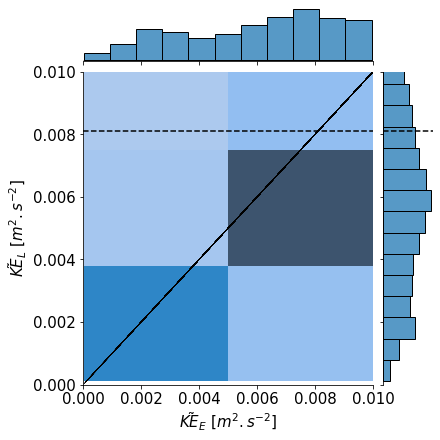

In [101]:
_El = (ds_hf_dl2.L_energy).values.flatten()
_Ee = (ds_hf_dl2.E_energy).values.flatten()
axs = sns.jointplot(x=_Ee,y=_El,kind='hist',xlim=(0,0.01),ylim=(0,0.01),bins=1000)
axs.set_axis_labels(r'$\tilde{KE}_E$ [$m^2.s^{-2}$]',r'$\tilde{KE}_L$ [$m^2.s^{-2}$]')
for ax in (axs.ax_joint, axs.ax_marg_x):
    ax.axvline(axs.x[axs.x<0.03].mean(), color='k', ls='--', lw=1.5)
for ax in (axs.ax_joint, axs.ax_marg_y):
    ax.axhline(axs.y[axs.y<0.03].mean(), color='k', ls='--', lw=1.5)
for ax in (axs.ax_joint, axs.ax_marg_x):
#axs.ax_joint.plot(np.sort(_Ee),np.sort(_El),c='k',lw=1.5)
    ax.plot(axs.x.values,axs.x.values, c='k', lw=0.5)

fig.savefig(fig_dir+'LE_joint.png')